In [1]:
cd ~/PycharmProjects/CleanSpace/momia2/

/Users/jzrolling/PycharmProjects/CleanSpace/momia2


In [2]:
import matplotlib.pyplot as plt, pandas as pd, numpy as np, tifffile,glob
from skimage import filters, morphology, feature, draw, measure, segmentation
import seaborn as sns
from matplotlib import colormaps as cm

# load momia2
import momia2 as mo

### Define customized functions

In [3]:
# customized S.pneumo profiler
def profiler(img_path,header,dst):
    #load data
    img = tifffile.imread(img_path)
    amask = tifffile.imread(img_path.split('.tif')[0]+'_antimask.tif')
    ph_bp = mo.utils.dual_bandpass(img[0],pixel_microns=0.04968,min_structure_scale=0.01,max_structure_scale=10)
    g1 = filters.gaussian(ph_bp,preserve_range=True,sigma=0.5)
    g2 = filters.gaussian(ph_bp,preserve_range=True,sigma=10)
    norm = g1/g2
    th = filters.threshold_isodata(norm)
    fg = (norm<th)*1
    shapeid = feature.shape_index(norm,sigma=2)
    shapeid = (shapeid+1)/2
    masked_shapeid = fg*shapeid
    dilated = morphology.binary_dilation(fg,morphology.disk(3))
    chain_labels = measure.label(dilated)
    
    shape_id_th = filters.threshold_isodata(masked_shapeid)
    binary_seed = (masked_shapeid<0.35)&(masked_shapeid>0.05)
    binary_seed = morphology.opening(binary_seed,morphology.disk(2))
    binary_seed = morphology.remove_small_holes(binary_seed,200)
    binary_seed = morphology.remove_small_objects(binary_seed,100)
    
    sobel = filters.sobel(norm)
    watersheded = segmentation.watershed(sobel,markers=measure.label(binary_seed),mask = fg, 
                                         watershed_line=True,compactness=100)

    dapi = mo.utils.subtract_background(img[2].copy())
    dapi_norm = mo.utils.normalize_image(dapi,mask=dilated,min_perc=0.5,max_perc=99.5)

    dapi_masked = dapi*fg
    dapi_binarized = (morphology.binary_opening((dapi_masked>filters.threshold_isodata(dapi_masked)*1.5),morphology.disk(3))).astype(int) #1.2
    
    # extract cells
    p1 = mo.Patch(image_dict={'C1':norm.copy(),'C2':dapi,'C3':amask,'C4':dapi_binarized},ref_channel='C1',
                  image_id='{}_cell'.format(header))
    p1.pixel_microns = 0.04968
    p1.labeled_mask=watersheded
    p1.mask=fg
    p1.locate_particles()
    p1.find_outline(use_binary=True,level=0.01,smooth_level=12)
    p1.extract_midlines()
    p1.get_intensity_stats()
    p1.get_morphology_stats()
    
    # extract chains
    p2 = mo.Patch(image_dict={'C1':norm.copy(),'C2':img[2].copy(),'C3':amask,'C4':dapi_binarized},ref_channel='C1',image_id='{}_chain'.format(header))
    p1.pixel_microns = 0.04968
    p2.labeled_mask=chain_labels
    p2.mask=fg
    p2.locate_particles()
    p2.find_outline(use_binary=True,level=0.05,
                    tolerance=0.9,interp_distance=2,smooth_level=1)
    p2.extract_midlines(max_iteration=15)
    p2.get_intensity_stats()
    p2.get_morphology_stats()
    print('Data loaded')
    #match cell with chain
    parent = []
    cell_profiles = []
    chain_profiles = []
    for i,(c,midline,x0,y0) in enumerate(p1.regionprops[['$coords','$midlines','$opt-x1','$opt-y1']].values):
        label = p1.regionprops.index[i]
        x,y = c[:,0],c[:,1]
        v = chain_labels[x,y]
        chain_label = np.unique(v[v!=0])[0]
        chain_id = '{}_chain_{}'.format(header,chain_label)
        cropped = p1.get_particle_data(label)['C2']
        if len(midline)==1:
            try:
                cell_profiles.append(mo.utils.measure_along_strip(midline[0],cropped,width=5))
            except:
                cell_profiles.append([])
        else:
            cell_profiles.append([])
        parent.append(chain_id)

    print('Cell profiling done.')
    for i,(c,midline,x0,y0) in enumerate(p2.regionprops[['$coords','$midlines','$opt-x1','$opt-y1']].values):
        label = p2.regionprops.index[i]
        x,y = c[:,0],c[:,1]
        cropped = p2.get_particle_data(label)['C2']
        if len(midline)==1:
            try:
                chain_profiles.append(mo.utils.measure_along_strip(midline[0],cropped,width=5))
            except:
                chain_profiles.append([])
        else:
            chain_profiles.append([])
    p1.regionprops['$midline_profile']=cell_profiles
    p2.regionprops['$midline_profile']=chain_profiles
    p1.regionprops['Parent_chain']=parent
    mo.pickle_save(p1.regionprops,dst+'{}_Cell.pk'.format(header))
    mo.pickle_save(p2.regionprops,dst+'{}_Chain.pk'.format(header))
    p1.plot(figsize=(20,20))
    plt.axis('off')
    plt.savefig(dst+header+'_cell.png',dpi=160,bbox_inches='tight')
    plt.close()
    p2.plot(figsize=(20,20))
    plt.axis('off')
    plt.savefig(dst+header+'_chain.png',dpi=160,bbox_inches='tight')
    plt.close()
    return p1,p2

### Image analysis with MOMIA2

In [11]:
# run profiler for all samples

"""
for header,conc in zip(['203 0 IPTG.lif','203 40 mM IPTG.lif','203 100 mM IPTG.lif'],
                       ['0mM','40mM','100mM']):

for header,conc in zip(['203 100 mM IPTG 3.lif'],
                       ['100mM']):
    for f in sorted(glob.glob('/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/batch1_tiffs/{} - Image*.tif'.format(header))):
        if 'antimask' not in f:
            img_id = int(f.split('Image')[1].split('.')[0])
            p1,p2 = profiler(f,'{}_{}'.format(conc,img_id),'/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/batch1_pickled/')
"""

"""
for header,conc in zip(['parB 203 0 IPTG.lif','parB 203 40 mM IPTG.lif','parB 203 100 mM IPTG.lif',\
                        'SMC 203 0 IPTG.lif','SMC 203 40 mM.lif','SMC 203 100 mM.lif'],['parB_0mM','parB_40mM','parB_100mM','SMC_0mM','SMC_40mM','SMC_100mM']):
"""
i=0
for header,conc in zip(['SMC 203 0 IPTG.lif','SMC 203 100 mM.lif'],['SMC_0mM','SMC_100mM']):
    for f in sorted(glob.glob('/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/batch2_tiffs/{} - Image*.tif'.format(header))):
        if 'antimask' not in f:
            img_id = int(f.split('Image')[1].split('.')[0])
            p1,p2 = profiler(f,'{}_{}'.format(conc,img_id),'/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/batch2_pickled/')
            i+=1
        if i==2:
            break
    break

Data loaded
Cell profiling done.
Rendering cell plot(s)...
Rendering cell plot(s)...
Data loaded
Cell profiling done.
Rendering cell plot(s)...
Rendering cell plot(s)...


### Load pickled cell and chain data

In [433]:
# load pickled data
cell_merged = []
chain_merged = []
for f in sorted(glob.glob('/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/batch1_pickled/*Cell.pk')):
    df = mo.pickle_load(f)
    cond = f.split('/')[-1].split('_')[0]
    df['IPTG_concentration']=cond
    df['Strain'] = '203'
    cell_merged.append(df)

for f in sorted(glob.glob('/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/batch2_pickled/*Cell.pk')):
    df = mo.pickle_load(f)
    strain, cond = f.split('/')[-1].split('_')[:2]
    df['IPTG_concentration']=cond
    df['Strain'] = strain
    cell_merged.append(df)
    
for f in sorted(glob.glob('/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/batch1_pickled/*Chain.pk')):
    df = mo.pickle_load(f)
    cond = f.split('/')[-1].split('_')[0]
    df['IPTG_concentration']=cond
    df['Strain']='203'
    chain_merged.append(df)

for f in sorted(glob.glob('/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/batch2_pickled/*Chain.pk')):
    df = mo.pickle_load(f)
    strain, cond = f.split('/')[-1].split('_')[:2]
    df['IPTG_concentration']=cond
    df['Strain'] = strain
    chain_merged.append(df)
    
cell_merged = pd.concat(cell_merged)
chain_merged = pd.concat(chain_merged)

# remove incorrectly segmented outliers
chain_filtered = chain_merged[(chain_merged['width_median [µm]']>1)&(chain_merged['width_median [µm]']<1.75)&(chain_merged['C3_mean']<10)]
cell_filtered = cell_merged[(cell_merged['width_median [µm]']>0.5)&(cell_merged['width_median [µm]']<1)&(cell_merged['C3_mean']<10)]

### Render plots and statistics

#### We will only use 100mM vs. 0mM for clarity

In [434]:
chain_subset = chain_filtered[chain_filtered['IPTG_concentration']!='40mM'].copy()
cell_subset = cell_filtered[cell_filtered['IPTG_concentration']!='40mM'].copy()

#### Chain length

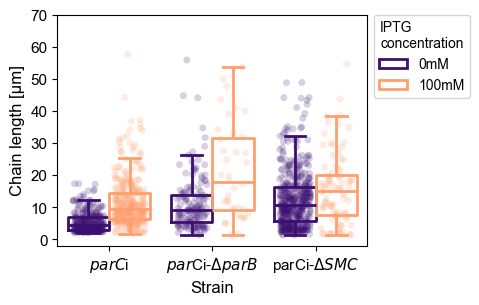

In [510]:
# compare chain lengths
colors = [np.array(cm.get_cmap('magma')(i)) for i in [0.2,0.8]]
sns.set_palette(colors)
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot()
sns.boxplot(data=chain_subset,x='Strain',
               y='length [µm]',hue='IPTG_concentration',linewidth=2,
               order=['203','parB','SMC'],zorder=55,hue_order=['0mM','100mM'],
               fill=False,fliersize=0,saturation=1)

sns.stripplot(data=chain_subset,x='Strain',
               y='length [µm]',
               hue='IPTG_concentration',order=['203','parB','SMC'], dodge=True,legend=False,
               hue_order=['0mM','100mM'],alpha=0.2,zorder=1,s=5,jitter=0.3,edgecolor='black')

l = plt.legend(loc=(1.02,0.64),prop={'family':'Arial','size':10})
l.set_title('IPTG\nconcentration',prop={'family':'Arial','size':10})
ax.set_ylim(-2,70)
ax.set_xticklabels(['$parC$i','$par$Ci-$\\Delta$$parB$','parCi-$\\Delta$$SMC$'],fontsize=11,fontname='Arial')
ax.set_yticklabels([int(x) for x in ax.get_yticks()],fontsize=11,fontname='Arial');
ax.set_ylabel('Chain length [µm]',fontsize=12,fontname='Arial')
ax.set_xlabel('Strain',fontsize=12,fontname='Arial')
plt.savefig('/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/pub_plots/chain_length.svg',bbox_inches='tight')

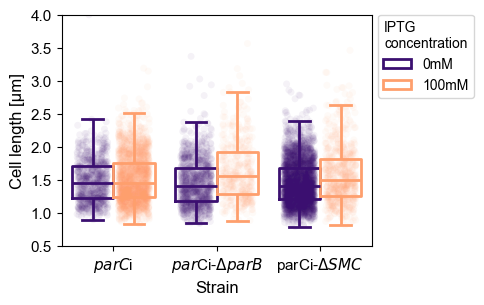

In [511]:
# compare chain lengths
colors = [np.array(cm.get_cmap('magma')(i)) for i in [0.2,0.8]]
sns.set_palette(colors)
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot()
sns.boxplot(data=cell_subset,x='Strain',
               y='length [µm]',hue='IPTG_concentration',linewidth=2,
               order=['203','parB','SMC'],zorder=55,hue_order=['0mM','100mM'],
               fill=False,fliersize=0,saturation=1)

sns.stripplot(data=cell_subset,x='Strain',
               y='length [µm]',
               hue='IPTG_concentration',order=['203','parB','SMC'], dodge=True,legend=False,
               hue_order=['0mM','100mM'],alpha=0.05,zorder=1,s=5,jitter=0.3,edgecolor='black')

l = plt.legend(loc=(1.02,0.64),prop={'family':'Arial','size':10})
l.set_title('IPTG\nconcentration',prop={'family':'Arial','size':10})
ax.set_ylim(0.5,4)
ax.set_xticklabels(['$parC$i','$par$Ci-$\\Delta$$parB$','parCi-$\\Delta$$SMC$'],fontsize=11,fontname='Arial')
ax.set_yticklabels([round(x,2) for x in ax.get_yticks()],fontsize=11,fontname='Arial');
ax.set_ylabel('Cell length [µm]',fontsize=12,fontname='Arial')
ax.set_xlabel('Strain',fontsize=12,fontname='Arial')
plt.savefig('/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/pub_plots/cell_length.svg',bbox_inches='tight')

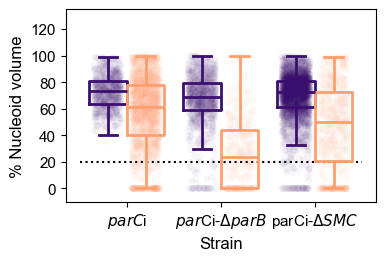

In [512]:
# compare chain lengths
colors = [np.array(cm.get_cmap('magma')(i)) for i in [0.2,0.8]]
sns.set_palette(colors)
fig=plt.figure(figsize=(4,2.5))
ax=fig.add_subplot()
sns.boxplot(data=cell_subset,x='Strain',
               y='C4_mean',hue='IPTG_concentration',linewidth=2,
               order=['203','parB','SMC'],zorder=55,hue_order=['0mM','100mM'],
               fill=False,fliersize=0,saturation=1,legend=False)

sns.stripplot(data=cell_subset,x='Strain',
               y='C4_mean',
               hue='IPTG_concentration',order=['203','parB','SMC'], dodge=True,legend=False,
               hue_order=['0mM','100mM'],alpha=0.03,zorder=1,s=5,jitter=0.3,edgecolor='black')

#l = plt.legend(loc=(1.02,0.64),prop={'family':'Arial','size':10})
#l.set_title('IPTG\nconcentration',prop={'family':'Arial','size':10})
ax.set_ylim(-0.1,1.35)
ax.set_xticklabels(['$parC$i','$par$Ci-$\\Delta$$parB$','parCi-$\\Delta$$SMC$'],fontsize=11,fontname='Arial')
ax.set_yticklabels([int(x*100) for x in ax.get_yticks()],fontsize=11,fontname='Arial');
ax.set_ylabel('% Nucleoid volume',fontsize=12,fontname='Arial')
ax.set_xlabel('Strain',fontsize=12,fontname='Arial')
ax.hlines(0.2,-0.5,2.5,color='black',ls=':')
plt.savefig('/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/pub_plots/nuc_frac_box.svg',bbox_inches='tight')

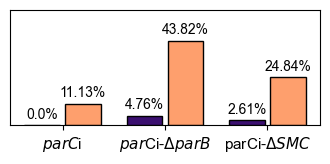

In [513]:
# compare chain lengths
colors = [np.array(cm.get_cmap('magma')(i)) for i in [0.2,0.8]]
sns.set_palette(colors)
fig=plt.figure(figsize=(4,1.5))
ax=fig.add_subplot()

for i,strain in enumerate(['203','parB','SMC']):
    strain_data = cell_subset[cell_subset['Strain']==strain]
    ctrl = strain_data[strain_data['IPTG_concentration']=='0mM']
    iptg = strain_data[strain_data['IPTG_concentration']=='100mM']

    ctrl_frac = (ctrl['C4_mean']>0.2).sum()/len(ctrl)
    iptg_frac = (iptg['C4_mean']>0.2).sum()/len(iptg)
    ax.bar(i-0.2,width=0.35,height=1-ctrl_frac,color=colors[0],ec='black')
    ax.bar(i+0.2,width=0.35,height=1-iptg_frac,color=colors[1],ec='black')
    ax.text(i-0.2,1-ctrl_frac+0.02,'{}%'.format(round((1-ctrl_frac)*100,2)),ha='center',va='bottom',fontsize=10,fontname='Arial')
    ax.text(i+0.2,1-iptg_frac+0.02,'{}%'.format(round((1-iptg_frac)*100,2)),ha='center',va='bottom',fontsize=10,fontname='Arial')

#l = plt.legend(loc=(1.02,0.64),prop={'family':'Arial','size':10})
#l.set_title('IPTG\nconcentration',prop={'family':'Arial','size':10})
ax.set_ylim(0,0.6)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['$parC$i','$par$Ci-$\\Delta$$parB$','parCi-$\\Delta$$SMC$'],fontsize=11,fontname='Arial')
ax.set_yticks([]);
plt.savefig('/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/pub_plots/nuc_frac_bar.svg',bbox_inches='tight')

In [483]:
colors[1]

array([0.994738, 0.62435 , 0.427397, 1.      ])

Text(0.5, 0, 'Strain')

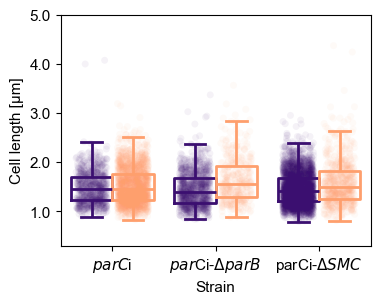

In [437]:
# compare chain lengths
colors = [np.array(cm.get_cmap('magma')(i)) for i in [0.2,0.8]]
sns.set_palette(colors)
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot()
sns.boxplot(data=cell_subset,x='Strain',
               y='length [µm]',hue='IPTG_concentration',linewidth=2,
               order=['203','parB','SMC'],zorder=55,hue_order=['0mM','100mM'],
               fill=False,fliersize=0,saturation=1,legend=False)



#l = plt.legend(loc=(1.02,0.64),prop={'family':'Arial','size':10})
#l.set_title('IPTG\nconcentration',prop={'family':'Arial','size':10})
ax.set_ylim(0.3,5)
ax.set_xticklabels(['$parC$i','$par$Ci-$\\Delta$$parB$','parCi-$\\Delta$$SMC$'],fontsize=11,fontname='Arial')
ax.set_yticklabels([round(x,2) for x in ax.get_yticks()],fontsize=11,fontname='Arial');
ax.set_ylabel('Cell length [µm]',fontsize=11,fontname='Arial')
ax.set_xlabel('Strain',fontsize=11,fontname='Arial')

Text(0.5, 0, 'Strain')

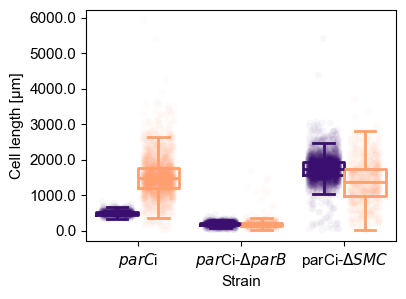

In [438]:
# compare chain lengths
colors = [np.array(cm.get_cmap('magma')(i)) for i in [0.2,0.8]]
sns.set_palette(colors)
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot()
sns.boxplot(data=cell_subset,x='Strain',
               y='C2_mean',hue='IPTG_concentration',linewidth=2,
               order=['203','parB','SMC'],zorder=55,hue_order=['0mM','100mM'],
               fill=False,fliersize=0,saturation=1,legend=False)

sns.stripplot(data=cell_subset,x='Strain',
               y='C2_mean',
               hue='IPTG_concentration',order=['203','parB','SMC'], dodge=True,legend=False,
               hue_order=['0mM','100mM'],alpha=0.03,zorder=1,s=5,jitter=0.3,edgecolor='black')

#l = plt.legend(loc=(1.02,0.64),prop={'family':'Arial','size':10})
#l.set_title('IPTG\nconcentration',prop={'family':'Arial','size':10})
#ax.set_ylim(-0.1,1.2)
ax.set_xticklabels(['$parC$i','$par$Ci-$\\Delta$$parB$','parCi-$\\Delta$$SMC$'],fontsize=11,fontname='Arial')
ax.set_yticklabels([round(x,2) for x in ax.get_yticks()],fontsize=11,fontname='Arial');
ax.set_ylabel('Cell length [µm]',fontsize=11,fontname='Arial')
ax.set_xlabel('Strain',fontsize=11,fontname='Arial')
#ax.hlines(0.2,-0.5,2.5,color='black',ls=':')

In [523]:
from scipy import stats

strain_dict = {'203':'parCi','parB':'parCi_del-parB','SMC':'parCi-del-SMC'}
chain_subset['Sample_key'] = ['{}_{}'.format(strain_dict[x],y) for x,y in chain_subset[['Strain','IPTG_concentration']].values]
cell_subset['Sample_key'] = ['{}_{}'.format(strain_dict[x],y) for x,y in cell_subset[['Strain','IPTG_concentration']].values]

stat_table = []
sample_keys = chain_subset['Sample_key'].unique()
columns = ['Sample-1','Sample-2','Chain_length, MannWhitneyU-pval','Cell_length, MannWhitneyU-pval',
           'Cell_width, MannWhitneyU-pval','Nucleoid_fraction, MannWhitneyU-pval']
for i in range(len(sample_keys)-1):
    for j in range(i+1,len(sample_keys)):
        k1 = sample_keys[i]
        k2 = sample_keys[j]
        chain1,chain2 = chain_subset[chain_subset['Sample_key']==k1],chain_subset[chain_subset['Sample_key']==k2]
        cell1,cell2 = cell_subset[cell_subset['Sample_key']==k1],cell_subset[cell_subset['Sample_key']==k2]
        mwu_p1 = stats.mannwhitneyu(chain1['length [µm]'].values,chain2['length [µm]'].values)[1]
        mwu_p2 = stats.mannwhitneyu(cell1['length [µm]'].values,cell2['length [µm]'].values)[1]
        mwu_p3 = stats.mannwhitneyu(cell1['width_median [µm]'].values,cell2['width_median [µm]'].values)[1]
        mwu_p4 = stats.mannwhitneyu(cell1['C4_mean'].values,cell2['C4_mean'].values)[1]
        stat_table.append([k1,k2,mwu_p1,mwu_p2,mwu_p3,mwu_p4])
stat_df = pd.DataFrame(stat_table,columns=columns)
stat_df.to_excel('/Users/jzrolling/Desktop/Projects/SZU/XueLiu/SP_image_analysis/pub_plots/stats.xlsx')

Rendering cell plot(s)...


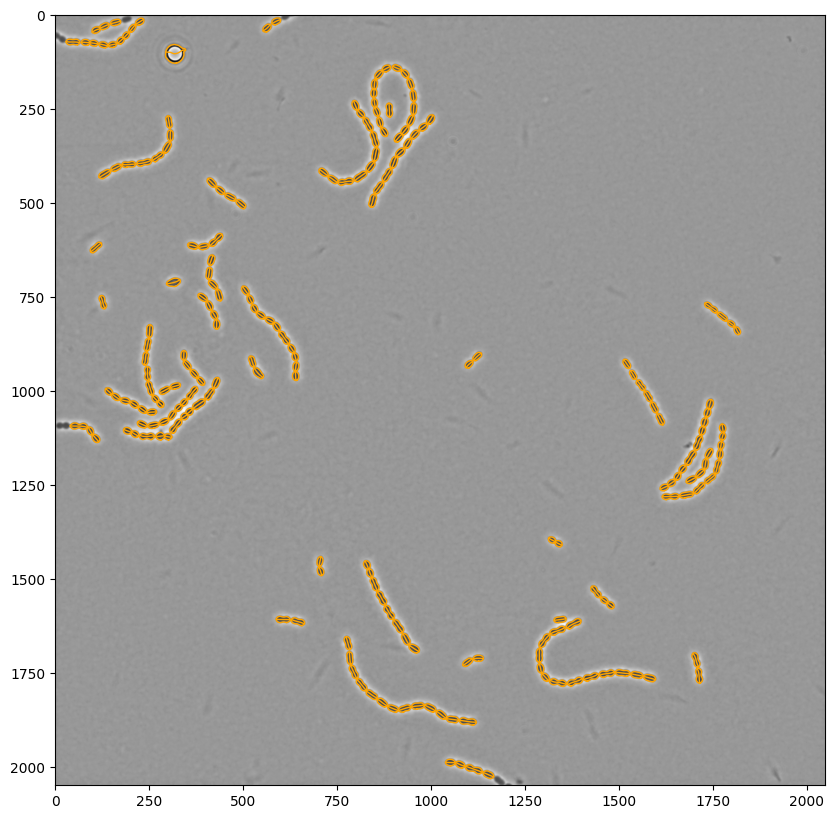

In [12]:
p1.plot(figsize=(10,10))

Rendering cell plot(s)...


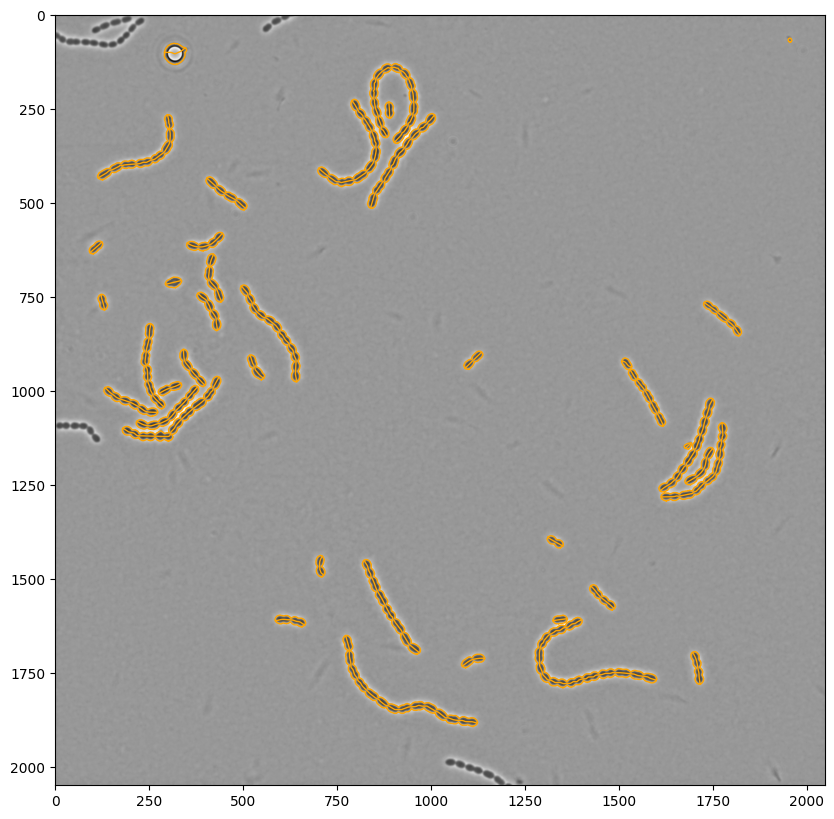

In [13]:
p2.plot(figsize=(10,10))